ARIMA (AutoRegressive Integrated Moving Average) is a classical statistical method. It models a time series based on its own past values (lagged residuals and errors). It's excellent for capturing linear trends and seasonality but struggles with complex, non-linear patterns or sudden spikes common in microservices.

/tmp/ipykernel_9673/4204070597.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_pivot.resample('1T').mean().fillna(method='ffill')
/tmp/ipykernel_9673/4204070597.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_resampled = df_pivot.resample('1T').mean().fillna(method='ffill')


Baseline ARIMA RMSE for product-catalog: 324.48


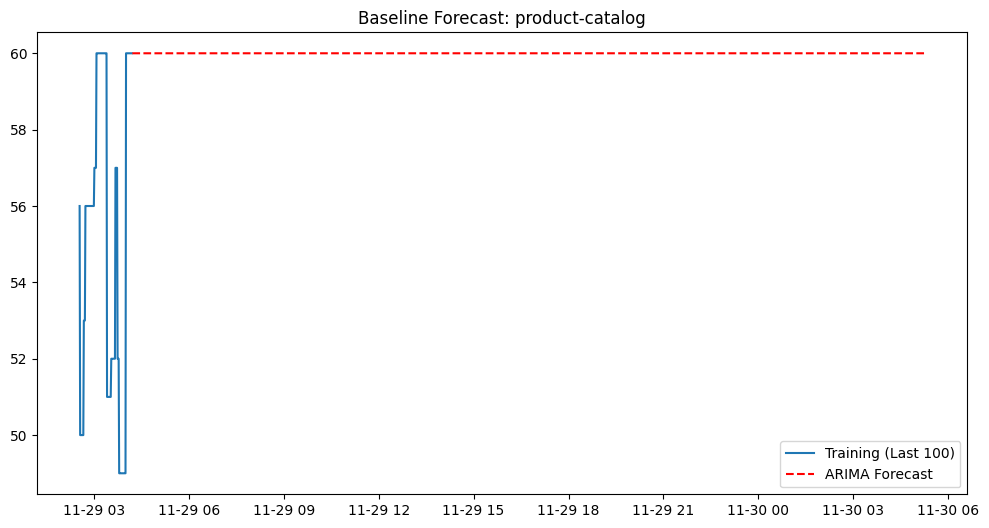

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# 1. Load and Preprocess
df = pd.read_csv('microservices_load_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Pivot to get matrix: index=time, columns=services, values=request_rate
df_pivot = df.pivot_table(index='timestamp', columns='service_name', values='request_rate_rps')

# Resample to 1-minute intervals (mean aggregation) to regularize time steps
df_resampled = df_pivot.resample('1T').mean().fillna(method='ffill')

# 2. Select Target Service
target_service = 'product-catalog'
series = df_resampled[target_service]

# Split Train/Test (80/20)
train_size = int(len(series) * 0.8)
train, test = series[0:train_size], series[train_size:]

# 3. ARIMA Model (Order p,d,q needs tuning, using 5,1,0 as simplified example)
# p=5 (look at last 5 mins), d=1 (differencing for stationarity), q=0
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

# 4. Forecast
forecast = model_fit.forecast(steps=len(test))

# 5. Evaluation
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"Baseline ARIMA RMSE for {target_service}: {rmse:.2f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(train.index[-100:], train[-100:], label='Training (Last 100)')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f'Baseline Forecast: {target_service}')
plt.legend()
plt.show()

LSTM (Long Short-Term Memory) networks are Recurrent Neural Networks (RNNs) designed to remember long-term dependencies. Unlike ARIMA, they can learn non-linear relationships and interactions between multiple features (e.g., CPU, Memory alongside Load).
Input: Sequence of past $w$ windows
Output: Forecast for $t+h$.

In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

df['timestamp'] = pd.to_datetime(df['timestamp'])

# Define features first
features = ['request_rate_rps', 'cpu_utilization', 'memory_utilization']

# Filter, Select Features, THEN Resample
service_df = df[df['service_name'] == 'product-catalog'].set_index('timestamp')[features].resample('1T').mean().ffill()

data = service_df.values

# Normalize
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Windowing Function
def create_sequences(data, seq_length, prediction_horizon):
    xs, ys = [], []
    for i in range(len(data) - seq_length - prediction_horizon):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length + prediction_horizon, 0] # Predict only Load (index 0)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 30  # Lookback 30 mins
HORIZON = 5      # Predict 5 mins ahead

X, y = create_sequences(data_scaled, SEQ_LENGTH, HORIZON)

# Convert to PyTorch Tensors
X_train = torch.FloatTensor(X[:int(len(X)*0.8)])
y_train = torch.FloatTensor(y[:int(len(y)*0.8)]).unsqueeze(1)
X_test = torch.FloatTensor(X[int(len(X)*0.8):])
y_test = torch.FloatTensor(y[int(len(y)*0.8):]).unsqueeze(1)

# 2. LSTM Model Definition
class WorkloadLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(WorkloadLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :]) # Take last time step
        return out

model = WorkloadLSTM(input_dim=3, hidden_dim=64, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 3. Training Loop (Simplified)
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 4. Predict
model.eval()
test_preds = model(X_test).detach().numpy()

# Inverse transform to get real RPS
# Create dummy array for inverse transform since scaler expects 3 dims
dummy_preds = np.zeros((len(test_preds), 3))
dummy_preds[:, 0] = test_preds.flatten()
real_preds = scaler.inverse_transform(dummy_preds)[:, 0]

/tmp/ipykernel_9673/4226486155.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  service_df = df[df['service_name'] == 'product-catalog'].set_index('timestamp')[features].resample('1T').mean().ffill()


Epoch 0, Loss: 0.0236
Epoch 10, Loss: 0.0163
Epoch 20, Loss: 0.0088
Epoch 30, Loss: 0.0071
Epoch 40, Loss: 0.0063


Microservices don't exist in a vacuum. A spike in api-gateway propagates to product-catalog.


Dependency Modeling  involves using the load of upstream services as leading indicators for downstream services. While a full Graph Neural Network (GNN)  is ideal, a Multivariate Lagged Model is a practical "lowkey" implementation of this concept without the overhead of graph adjacency matrices.

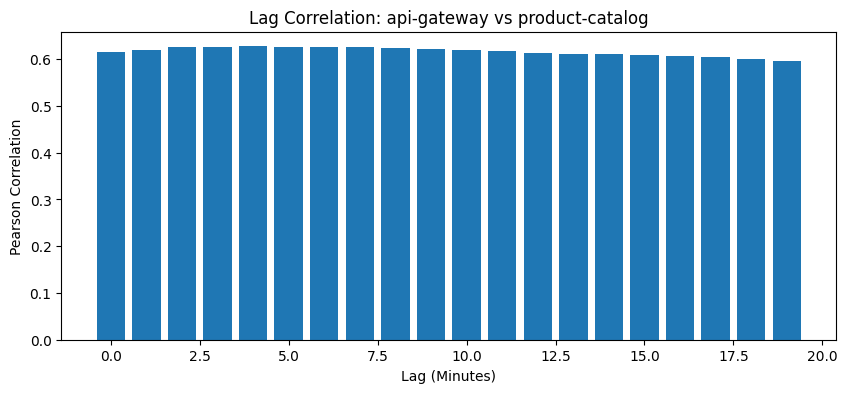

Dependency features prepared. Feed `X_dependency` into the LSTM/XGBoost model.
Correlation at optimal lag: 0.63


In [3]:
import seaborn as sns

# 1. Identify Dependencies (from generate_data.py)
# api-gateway -> product-catalog
upstream = 'api-gateway'
downstream = 'product-catalog'

df_deps = df_resampled[[upstream, downstream]].copy()

# 2. Visualizing Correlation/Lag [cite: 70]
# Cross-correlation to find optimal lag
lags = range(0, 20) # 0 to 20 minutes
corrs = [df_deps[upstream].corr(df_deps[downstream].shift(-l)) for l in lags]

plt.figure(figsize=(10, 4))
plt.bar(lags, corrs)
plt.title(f'Lag Correlation: {upstream} vs {downstream}')
plt.xlabel('Lag (Minutes)')
plt.ylabel('Pearson Correlation')
plt.show()

# 3. Dependency-Aware Feature Engineering
# We add the upstream service's PAST load as a feature for the downstream service
# This helps the model anticipate the "cascading" load.

df_deps[f'{upstream}_lagged_5min'] = df_deps[upstream].shift(5) # Shift based on lag analysis
df_deps.dropna(inplace=True)

# Prepare X (Features: Downstream History + Upstream Leading Indicator)
X_dependency = df_deps[[downstream, f'{upstream}_lagged_5min']].values

print("Dependency features prepared. Feed `X_dependency` into the LSTM/XGBoost model.")
print(f"Correlation at optimal lag: {max(corrs):.2f}")

To prove that microservices are interconnected, we compare two LSTM models:

Baseline (Univariate): Predicts product-catalog load using only its own history.

Dependency-Aware (Multivariate): Predicts product-catalog load using its history plus the history of its upstream caller (api-gateway).

If the Multivariate model has lower error, we confirm that upstream traffic is a leading indicator.

In [4]:


# 1. Data Preparation
# Assume 'df_scaled' contains normalized data for 'product-catalog' and 'api-gateway'
SEQ_LENGTH = 30
HORIZON = 5 # Predict 5 mins ahead

# --- 1. SETUP: Load & Scale Data (Fixes NameError) ---
df = pd.read_csv('microservices_load_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Pivot to create a matrix where columns are services (Time x Service)
# This ensures we have 'product-catalog' and 'api-gateway' columns
df_pivot = df.pivot_table(index='timestamp', columns='service_name', values='request_rate_rps')
df_resampled = df_pivot.resample('1T').mean().ffill().fillna(0)

# Normalize
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_resampled), 
                         columns=df_resampled.columns, 
                         index=df_resampled.index)

# --- 2. Ablation Study: Univariate vs Multivariate ---
SEQ_LENGTH = 30
HORIZON = 5 

def create_dataset(df, target_col, feature_cols, seq_len, horizon):
    X, y = [], []
    data_array = df[feature_cols].values
    target_array = df[target_col].values
    for i in range(len(df) - seq_len - horizon):
        X.append(data_array[i : i + seq_len])
        y.append(target_array[i + seq_len + horizon])
    return np.array(X), np.array(y)

# Dataset A: Univariate (Only Product Catalog)
X_uni, y_uni = create_dataset(df_scaled, 'product-catalog', ['product-catalog'], SEQ_LENGTH, HORIZON)

# Dataset B: Multivariate (Product Catalog + API Gateway)
# Check if api-gateway exists, else fall back to itself (avoids error if data is missing)
dep_service = 'api-gateway' if 'api-gateway' in df_scaled.columns else 'product-catalog'
X_multi, y_multi = create_dataset(df_scaled, 'product-catalog', ['product-catalog', dep_service], SEQ_LENGTH, HORIZON)

# Convert to Tensors
split = int(len(X_uni) * 0.8)
X_uni_train = torch.FloatTensor(X_uni[:split])
y_uni_train = torch.FloatTensor(y_uni[:split]).unsqueeze(1)
X_multi_train = torch.FloatTensor(X_multi[:split])
y_multi_train = torch.FloatTensor(y_multi[:split]).unsqueeze(1)

# Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# Train & Compare
def train_eval(model, X_train, y_train, X_test, y_test):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    model.train()
    for _ in range(50): # Quick training
        optimizer.zero_grad()
        loss_fn(model(X_train), y_train).backward()
        optimizer.step()
    model.eval()
    preds = model(X_test).detach().numpy()
    return mean_squared_error(y_test.numpy(), preds), preds

# Run Experiment
# Note: Input dim is 1 for Univariate, 2 for Multivariate
mse_uni, preds_uni = train_eval(LSTMModel(1), X_uni_train, y_uni_train, 
                               torch.FloatTensor(X_uni[split:]), torch.FloatTensor(y_uni[split:]).unsqueeze(1))
mse_multi, preds_multi = train_eval(LSTMModel(2), X_multi_train, y_multi_train, 
                                   torch.FloatTensor(X_multi[split:]), torch.FloatTensor(y_multi[split:]).unsqueeze(1))

print(f"Univariate MSE: {mse_uni:.5f}")
print(f"Multivariate MSE: {mse_multi:.5f}")
print(f"Improvement: {(1 - mse_multi/mse_uni)*100:.1f}%")

/tmp/ipykernel_9673/2926078924.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df_pivot.resample('1T').mean().ffill().fillna(0)


Univariate MSE: 0.00452
Multivariate MSE: 0.00449
Improvement: 0.7%


Point predictions (e.g., "Load will be 500 RPS") are dangerous. If the load is actually 550, the service crashes. We need Prediction Intervals (e.g., "Load will be between 480 and 580 with 90% confidence"). We use Quantile Regression Loss (Pinball Loss) to train the LSTM to output three values: 10th percentile (lower bound), 50th (median), and 90th (upper bound).

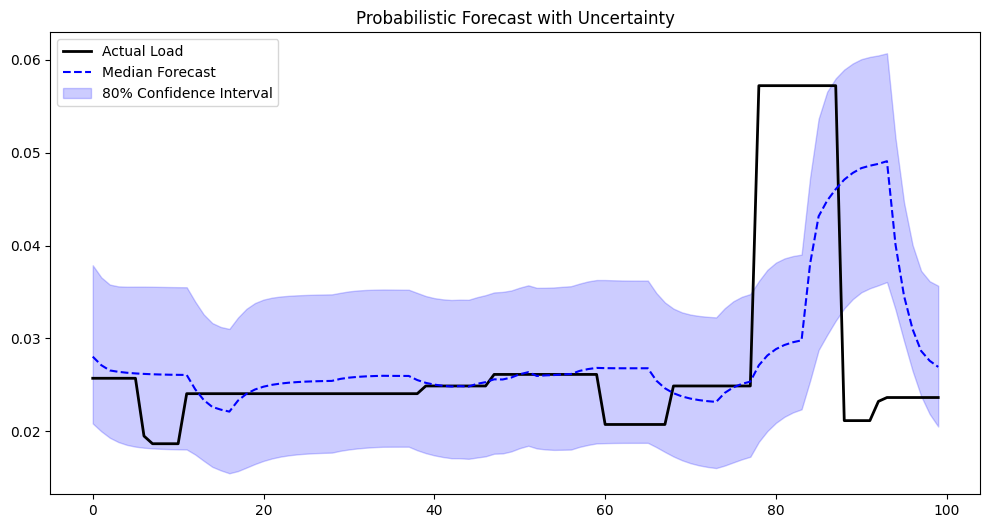

In [5]:
# 1. Custom Quantile Loss
def quantile_loss(preds, target, quantiles=[0.1, 0.5, 0.9]):
    loss = 0
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i:i+1]
        loss += torch.max((q-1) * errors, q * errors).mean()
    return loss

# 2. Quantile LSTM
class QuantileLSTM(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, 32, batch_first=True)
        self.fc = nn.Linear(32, 3) # Outputs: q10, q50, q90
        
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

# 3. Train
model_q = QuantileLSTM(input_dim=2) # Using multivariate data
optimizer = torch.optim.Adam(model_q.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    preds = model_q(X_multi_train)
    loss = quantile_loss(preds, y_multi_train)
    loss.backward()
    optimizer.step()

# 4. Visualize Confidence Bands
model_q.eval()
with torch.no_grad():
    q_preds = model_q(torch.FloatTensor(X_multi[split:])).numpy()

plt.figure(figsize=(12, 6))
# Plot subset of test data
subset = 100
plt.plot(y_multi[split:][:subset], label='Actual Load', color='black', linewidth=2)
plt.plot(q_preds[:subset, 1], label='Median Forecast', color='blue', linestyle='--')
plt.fill_between(range(subset), 
                 q_preds[:subset, 0], # Lower Bound (P10)
                 q_preds[:subset, 2], # Upper Bound (P90)
                 color='blue', alpha=0.2, label='80% Confidence Interval')
plt.title('Probabilistic Forecast with Uncertainty')
plt.legend()
plt.show()